In [20]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make

In [ ]:
Make()

In [42]:
class leastSquaresGD:
    def __init__(self, error):
        # original copies to reference back to
        self.x_original = None  
        self.a_original = None
        self.b_original = None
        # the copies
        self.x = None      # weights
        self.a = None      # xTrain
        self.b = None      # coeff
        self.initialTime = None # starting time
        self.error = error   # epsilon
        self.grad = None    # current gradient
        self.norm = None    # current norm of gradient
        self.lam = None     # current step size
        self.gr = None      # list of values of norms of gradient
        self.theta = None   # theta value used in Adpative
        # Plots for different methods
        self.vanPlt = None  
        self.AdapPlt = None
        self.LSPlt = None
        self.BazPlt = None
        self.Max = 0         # maximum value for x axis in plt
        self.time = None
        self.run = 30
        
    def get_ds(self, ds, Import = True):
        # can use 'make_regression', 'load_boston', 'fetch_california_housing', 'load_diabetes'
        if Import == True:
            dataset = ds(return_X_y=True)
        else:
            dataset = ds()
        self.a_original = dataset[0]
        self.b_original = dataset[1]
        self.x_original = np.random.rand(len(self.a_original[0]))
        
    def generate(self, function, dim, vec_len, scale):
        for i in range(dim):
            globals()['X'+str(i)] = [0]*vec_len
        for j in range(vec_len):
            globals()['X'+str(0)][j] = (random.random()+1e-12)*scale
            y = function(globals()['X'+str(0)][j])
            noiz = 3
            for k in range(dim):
                globals()['X'+str(k)][j] = y + np.random.normal(0,noiz)
                noiz += 3
        A = np.array([globals()['X'+str(i)] for i in range(dim)]).T
        self.a_original = A
        self.x_original = np.random.rand(len(A[0]))*scale
        self.b_original = A @ self.x_original + np.random.normal(0,3,(A @ self.x_original).shape)
        
    def f(self, X):
        return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
    def g(self, X):
        return self.a.T @ (self.a @ X - self.b)
    def Step(self):
        self.x = self.x - self.lam*self.grad
    
    def normal(self, X): 
        return np.linalg.norm(X)
    
    def Vanilla(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        self.lam = 1/L
        self.grad = self.g(self.x)
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            self.Step()
            self.grad = self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
            if time.time() - self.initialTime > self.run: # check within time limit
                break
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        print(' \n Vanilla Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr) > self.Max:
#             self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(self.Max,len(self.gr)) , 'g', self.vanPlt, 'Vanilla {} sec'.format(self.time))
#         self.SetPlots(0, min(len(self.gr),2000) , 'g', self.vanPlt, 'Vanilla {} sec'.format(self.time))
        self.PrintResults()
    
    def Adaptive(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.lam = random.random()+1e-12
        self.theta = float(random.getrandbits(128))
        oldX = deepcopy(self.x)
        self.grad = self.g(self.x)
        self.Step()
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam
            min2 = ( np.linalg.norm( self.x - oldX ) ) \
                / ( 2 * np.linalg.norm(self.g(self.x) - self.g(oldX) ) )
            self.lam = np.min([min1,min2])
            oldX = deepcopy(self.x)
            self.Step() # update x
            self.theta = self.lam/oldLam
            self.grad = self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
            if time.time() - self.initialTime > self.run: # check within time limit
                break
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        print('\n Adaptive Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr) > self.Max:
#             self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, min(self.Max,len(self.gr)) , 'y', self.AdapPlt, 'Adaptive {} sec'.format(self.time))
#         self.SetPlots(0, min(len(self.gr),2000) , 'y', self.AdapPlt, 'Adaptive {} sec'.format(self.time))
        self.PrintResults()
    
    def BackTrack(self):
        rho = random.random()
        lam = random.randrange(1e6)
        while lam > ( self.normal( lam * self.grad ) / \
                     ( self.normal( self.g( self.x - lam * self.grad ) - self.grad ) )  ):
            lam = rho * lam
        self.lam = lam

    def LineSearch(self):
        self.initialTime = time.time()
#         self.lam_list = []
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            self.BackTrack()
            self.Step()
            self.grad =  self.g(self.x)
            self.norm = self.normal(self.grad)
            self.gr.append(self.norm)
            if time.time() - self.initialTime > self.run: # check within time limit
                break
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        print('\n Line Search Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr) > self.Max:
#             self.Max = deepcopy(len(self.gr))
#         self.SetPlots(0, min(len(self.gr),2000) , 'b', self.LSPlt, 'LineSearch {} sec'.format(self.time))
        self.SetPlots(0, min(self.Max,len(self.gr)) , 'b', self.LSPlt, 'LineSearch {} sec'.format(self.time))
        self.PrintResults()
    
    def Barzilai(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.lam = random.random()+1e-12
        oldX = deepcopy(self.x)
        self.Step()
        self.norm = self.normal(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            self.lam = np.dot( self.x - oldX, self.g(self.x) - self.g(oldX) ) \
                        / np.linalg.norm(self.g(self.x) - self.g(oldX))**2
            oldX = deepcopy(self.x)
            self.Step()
            self.grad = self.g(self.x)
            self.norm =  self.normal(self.grad)
            self.gr.append( self.norm)
            if time.time() - self.initialTime > self.run: # check within time limit
                break
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        self.Max = len(self.gr)
        print('\n Barzilai-Borwein Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr) > self.Max:
#             self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, self.Max , 'r', self.BazPlt, 'Barzalai {} sec'.format(self.time))
#         self.SetPlots(0, min(len(self.gr),2000) , 'r', self.BazPlt, 'Barzalai {} sec'.format(self.time))
        self.PrintResults()
    
    def SetPlots(self, Min, Max, colour, name, label):
        name = plt.plot( range( Min, Max ) , self.gr[Min:Max] , c = colour , label = label)
    def PrintPlots(self):
        self.vanPlt
        self.AdapPlt
        self.LSPlt
        self.BazPlt
        plt.yscale('log')
#         plt.xscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc='best')
        plt.title(label = 'Norm of Gradient in domain [{}, {}]'.format(0,self.Max) )
        plt.savefig('plots2.png', dpi=100)
        plt.show()
    def PrintResults(self):
        print('At final iteration k =', len(self.gr), ':')
        print('x vector is:', self.x)
        print('Gradient Norm is:', self.norm)
        print('Time taken:', self.time)
        print('Final Lambda value: ', self.lam)

In [28]:
def linFunc(x):
    return 2*x + 5


 Barzilai-Borwein Gradient Descent:
_____________________________________________
At final iteration k = 168 :
x vector is: [0.07648202 0.15668486 0.85158445 0.89409098 0.62918254 0.99197664
 0.93374979 0.49089848 0.12029119 0.14496127]
Gradient Norm is: 9.870270601489e-09
Time taken: 0.02
Final Lambda value:  9.978905005337359e-06
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 1544 :
x vector is: [0.07648202 0.15668486 0.85158445 0.89409098 0.62918254 0.99197664
 0.93374979 0.49089848 0.12029119 0.14496127]
Gradient Norm is: 9.911451292126081e-09
Time taken: 0.03
Final Lambda value:  9.742426938827097e-06

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 269 :
x vector is: [0.07648202 0.15668486 0.85158445 0.89409098 0.62918254 0.99197664
 0.93374979 0.49089848 0.12029119 0.14496127]
Gradient Norm is: 9.355930105114524e-09
Time taken: 1.25
Final Lambda value:  1.119054060627613e-05



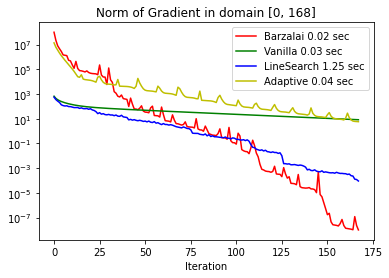

In [36]:
G = leastSquaresGD(1e-8)
G.generate(linFunc,10,100, 1)
G.Barzilai()
G.Vanilla()
G.LineSearch()
G.Adaptive()
G.PrintPlots()


 Barzilai-Borwein Gradient Descent:
_____________________________________________
At final iteration k = 40444 :
x vector is: [ 4.43048680e-02 -8.29690706e-03 -3.75233056e-02  2.70703931e-02
  2.30240630e-02 -6.43526787e-03 -6.21302857e-03  3.90340691e-02
  4.91374936e+01  3.37059371e-02  2.86732396e-02  3.14952990e-02
  3.33460189e-02 -4.60278220e-02 -5.12194886e-03  6.32092080e+01
 -2.83006376e-04 -1.60187157e-02 -3.96371297e-02  5.04972966e-02
 -2.76025132e-02  5.82032814e+01 -2.25915518e-02  1.65548728e-03
  4.61235567e-02 -4.33166347e-02  4.68117339e-02 -2.69066812e-02
  2.21542899e-02  8.67625107e+01  5.59481892e-02  9.79984472e-03
  2.38000991e-02  3.92412784e-02  9.62229536e+01  1.28591175e-02
  2.08695719e-02  1.11244888e-02  1.90899244e-02 -3.59414881e-02
 -3.79205415e-02  2.03614581e-02 -2.62070570e-02 -2.69540778e-02
 -5.68409780e-02 -1.14244710e-02 -2.35036324e-02  7.43262691e+01
 -2.97534132e-02 -6.96410405e-02 -1.25154239e-01  1.75224578e+01
  3.76048608e-02 -6.52127666

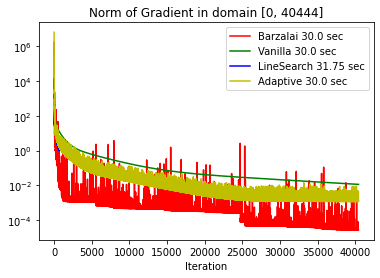

In [43]:
G = leastSquaresGD(1e-6)
G.get_ds(Make, Import=False)
G.Barzilai()
G.Vanilla()
G.LineSearch()
G.Adaptive()
G.PrintPlots()